In [3]:
import pandas as pd
import numpy as np
import random
import os
import lightgbm as lgb
import sys
sys.path.insert(0, '/media/DATA/zalo-hit-song-prediction/src/')
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.externals import joblib
import pandas as pd
from sklearn.externals import joblib
from format_features import baysianEncodeFeature
from format_features import format_features, assign_artist_features_inplace
from typecast_features import typecast_features
from utils import print_data_types
from utils import get_data, print_rmse

np.random.seed(1)
random.seed(1)
DATA_DIR="/media/DATA/zalo-hit-song-prediction/csv/"
df = get_data(DATA_DIR)
df = format_features(df)
all_features_in_order_list, df = typecast_features(df, cast_to_catcode=True)

print("Len before: ",len(df) )
# Remove len =0
df = df[(df.length>0) | (df.num_same_title==1)]

print("Len after: ",len(df) )
df = assign_artist_features_inplace(df)

###
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from format_features import create_album_score_lookup_table, create_artist_score_lookup_table, assign_value
from sklearn.model_selection import train_test_split
from typecast_features import cast_cat_dtype_to_cat_codes

chosen_features = ["album_right", "istrack11", "no_artist", "no_composer", "freq_artist", "freq_composer", "year",
                   "month", "hour", "day", "len_of_songname",
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover", "num_song_release_in_final_month",
                   "length", "genre", "track", "album_artist", "islyric", "album_artist_contain_artistname",
                   "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                   "isBeatAlbum", "isCoverAlbum", "artist_name", "composers_name", "copyright",
                   "artist_id_min_cat", "composers_id_min_cat", "artist_id_max_cat", "composers_id_max_cat",
                   "freq_artist_min", "freq_composer_min", "dayofyear", "weekday", "isHoliday",
                   "num_album_per_min_artist", "num_album_per_min_composer",
                   "numsongInAlbum", "isSingleAlbum_onesong", "artist_mean_id",
                   "artist_std_id", "artist_count_id", "title_cat", "num_same_title"]

chosen_features += ["predicted_label"]
# chosen_features += ["mean_album_score", "mean_artist_min_score"]
df_train = df[df.dataset == "train"]
df_test = df[df.dataset == "test"]

param = {
    'bagging_freq': 20,
    'bagging_fraction': 0.95, 'boost_from_average': 'false',
    'boost': 'gbdt', 'feature_fraction': 0.1, 'learning_rate': 0.001,
    'max_depth': -1, 'metric': 'root_mean_squared_error', 'min_data_in_leaf': 5,
    'num_leaves': 50,
    'num_threads': 8, 'tree_learner': 'serial', 'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501, 'verbosity': 1,
    "seed": 99999,
    "use_missing": True
}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)


There is 0.24038838760298156 ratio is nan album
There is 0.0017653981953707335 ratio is nan genre
There is 0.24038838760298156 ratio is nan album_artist
There is 0.0007846214201647705 ratio is nan track
There is 0.6722244017261672 ratio is nan lyric
2711 raw titles are identical between songs: 7485 unique titles
After cleaning brackets etc. only 6202 unique titles remain, i.e. 1283 are highly similar titles 
In making albumHashandName, we filled in: 146 values Of the total albumHashAndName 171 nan
In making albumHashAndNameAndReleaseday, we filled in the: 171 values remaining using the release second hash
There is a statistically signficiant relationship between English-like title and rank. So adding feature: isEnglishLikeTitle
Len before:  10190
Len after:  10183


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


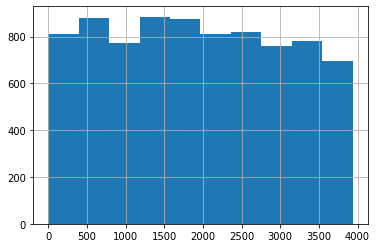

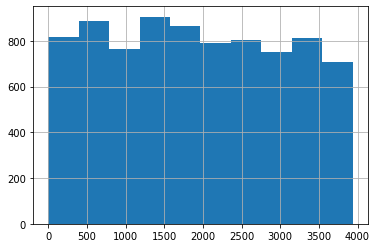

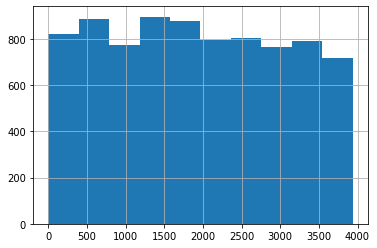

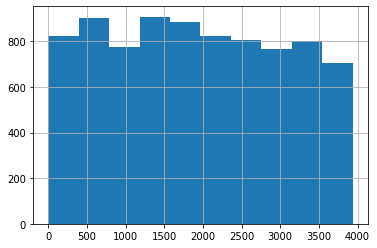

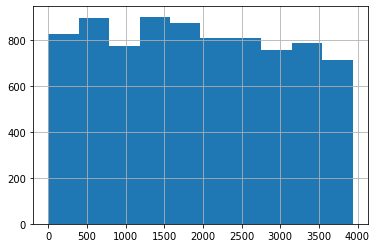

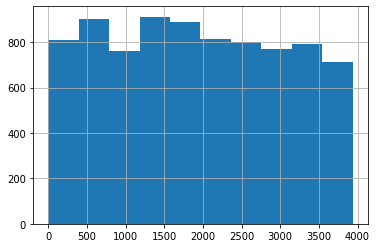

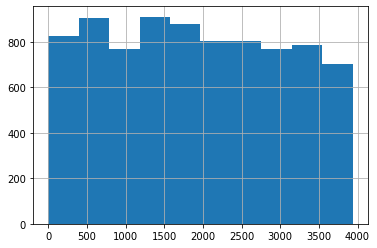

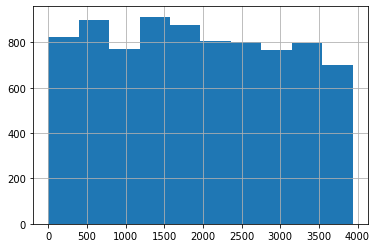

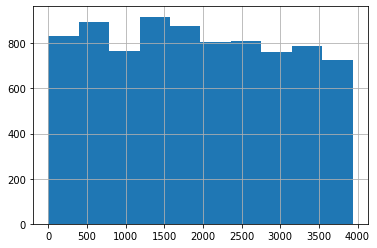

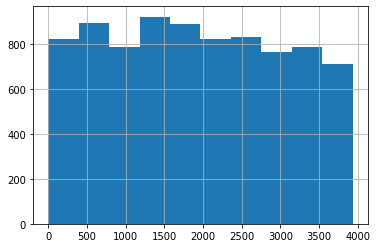

In [34]:
import matplotlib.pyplot as plt
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.album_right)):
    ax,fig = plt.subplots()
    print("Fold {}".format(fold_))
    df_train.iloc[trn_idx]['album_right'].hist()
    


In [40]:
from sklearn.utils import compute_sample_weight
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
labels = df_train.label
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.album_right)):
    print("Fold {}".format(fold_))

    # Create lookup table
    album_lookup_table = create_album_score_lookup_table(df_train.iloc[trn_idx])
    artist_lookup_table = create_artist_score_lookup_table(df_train.iloc[trn_idx])

    df_train["predicted_label"] = [assign_value(album_lookup_table, artist_lookup_table, r) for i, r in
                                   df_train.iterrows()]
    print("Percentage null in valid:", len(np.sum(df_train.iloc[val_idx].isnull())) / len(df_train.iloc[val_idx]))
    df_test["predicted_label"] = [assign_value(album_lookup_table, artist_lookup_table, r) for i, r in
                                  df_test.iterrows()]
    print("Percentage null in test:", len(np.sum(df_test.isnull())) / len(df_test))
    
    train_weights = compute_sample_weight('balanced', df_train.iloc[trn_idx].label)
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][chosen_features], 
                           label=labels.iloc[trn_idx],params={'verbose': -1},
                           free_raw_data=False,
                           weight=train_weights)
    val_data = lgb.Dataset(df_train.iloc[val_idx][chosen_features], 
                           label=labels.iloc[val_idx],params={'verbose': -1},
                           free_raw_data=False)
    clf = lgb.train(param, trn_data, 1000000, valid_sets=[trn_data, val_data], verbose_eval=5000,
                    early_stopping_rounds=20000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][chosen_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[chosen_features], num_iteration=clf.best_iteration) / folds.n_splits

from math import sqrt

print("RMSE: {:<8.5f}".format(sqrt(mean_squared_error(df_train.label, oof))))
sub = pd.DataFrame({"ID": df_test.ID.values})
sub["label"] = predictions.round(decimals=4)
mean_rmse, std_rmse = print_rmse(df_train, oof)
sub.to_csv(f"baseline3_withweightedKFoldAlbumRightStatification_{mean_rmse:.4f}_{std_rmse:.4f}.csv", index=False, header=False)


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Fold 0


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Percentage null in valid: 0.22839506172839505


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Percentage null in test: 0.19856887298747763
Training until validation scores don't improve for 20000 rounds
[5000]	training's rmse: 1.5889	valid_1's rmse: 1.75604
[10000]	training's rmse: 1.29595	valid_1's rmse: 1.62885
[15000]	training's rmse: 1.13115	valid_1's rmse: 1.57982
[20000]	training's rmse: 1.01264	valid_1's rmse: 1.55411
[25000]	training's rmse: 0.920523	valid_1's rmse: 1.53721
[30000]	training's rmse: 0.84501	valid_1's rmse: 1.52552
[35000]	training's rmse: 0.78108	valid_1's rmse: 1.51653
[40000]	training's rmse: 0.725208	valid_1's rmse: 1.50991
[45000]	training's rmse: 0.676565	valid_1's rmse: 1.50407
[50000]	training's rmse: 0.633079	valid_1's rmse: 1.49886
[55000]	training's rmse: 0.59376	valid_1's rmse: 1.49497
[60000]	training's rmse: 0.558479	valid_1's rmse: 1.49176
[65000]	training's rmse: 0.526471	valid_1's rmse: 1.48904
[70000]	training's rmse: 0.497013	valid_1's rmse: 1.48643
[75000]	training's rmse: 0.470094	valid_1's rmse: 1.48427
[80000]	training's rmse: 0.445

[45000]	training's rmse: 0.669187	valid_1's rmse: 1.60728
[50000]	training's rmse: 0.62614	valid_1's rmse: 1.6033
[55000]	training's rmse: 0.587907	valid_1's rmse: 1.60041
[60000]	training's rmse: 0.552982	valid_1's rmse: 1.59819
[65000]	training's rmse: 0.521261	valid_1's rmse: 1.59648
[70000]	training's rmse: 0.492171	valid_1's rmse: 1.59471
[75000]	training's rmse: 0.465791	valid_1's rmse: 1.59331
[80000]	training's rmse: 0.44127	valid_1's rmse: 1.59227
[85000]	training's rmse: 0.418834	valid_1's rmse: 1.59138
[90000]	training's rmse: 0.397875	valid_1's rmse: 1.59081
[95000]	training's rmse: 0.378433	valid_1's rmse: 1.59006
[100000]	training's rmse: 0.36017	valid_1's rmse: 1.58952
[105000]	training's rmse: 0.343451	valid_1's rmse: 1.58907
[110000]	training's rmse: 0.327684	valid_1's rmse: 1.58886
[115000]	training's rmse: 0.313012	valid_1's rmse: 1.58878
[120000]	training's rmse: 0.299119	valid_1's rmse: 1.58856
[125000]	training's rmse: 0.286183	valid_1's rmse: 1.58833
[130000]	tra

[155000]	training's rmse: 0.22458	valid_1's rmse: 1.51597
[160000]	training's rmse: 0.215538	valid_1's rmse: 1.51606
[165000]	training's rmse: 0.207186	valid_1's rmse: 1.51601
Early stopping, best iteration is:
[145274]	training's rmse: 0.243096	valid_1's rmse: 1.51585
Fold 7
Percentage null in valid: 0.24315443592552027
Percentage null in test: 0.19856887298747763
Training until validation scores don't improve for 20000 rounds
[5000]	training's rmse: 1.58635	valid_1's rmse: 1.77143
[10000]	training's rmse: 1.29362	valid_1's rmse: 1.64873
[15000]	training's rmse: 1.12918	valid_1's rmse: 1.60647
[20000]	training's rmse: 1.01064	valid_1's rmse: 1.58606
[25000]	training's rmse: 0.918733	valid_1's rmse: 1.57346
[30000]	training's rmse: 0.843965	valid_1's rmse: 1.56506
[35000]	training's rmse: 0.780094	valid_1's rmse: 1.55928
[40000]	training's rmse: 0.724149	valid_1's rmse: 1.55442
[45000]	training's rmse: 0.67577	valid_1's rmse: 1.55073
[50000]	training's rmse: 0.63264	valid_1's rmse: 1.5